In [7]:
#Ευφυή σύστημα όπου θα λάβουμε υπόψιν μόνο τις τιμές Tor και Non-Tor
#διότι αυτές σχετίζονται με το DarkNet

In [47]:
#εισαγωγή βιβλιοθηκών και πακέτων
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [49]:
#συνάρτηση εισαγωγής συνόλου δεδομένων σε δυο κλάσεις Tor = 1, Non-Tor = 0
def load_dataset(file_path):
    df = pd.read_csv(file_path)

    #Αφαίρεση μη χρήσιμων/μη αριθμητικών χαρακτηριστικών
    drop_cols = ['Src_IP', 'Dst_IP', 'Src_Port', 'Dst_Port', 'Label-2']
    df.drop(columns=drop_cols, errors='ignore', inplace=True)

    #αντικατάσταση Inf με NaN και διαγραφή NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    #κατανομή ετικετών
    df['Label'] = df['Label-1'].apply(lambda x:1 if x == "Tor" else 0)

    #διαγραφή της Label-1
    df.drop(columns=['Label-1'], inplace=True)

    X = df.drop('Label', axis=1).values
    y= df['Label']        #ο στόχος για ταξινόμηση

    return X, y, df

In [50]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv'

In [51]:
#φόρτωση συνόλου δεδομένων
X, y, df = load_dataset(csv_file_path)

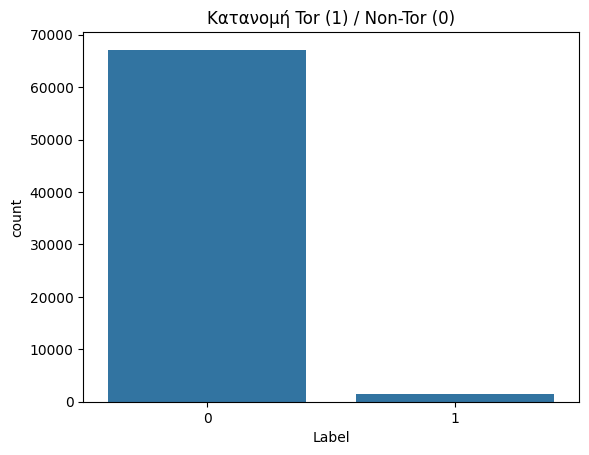

Null values:
 Series([], dtype: int64)

 Χαρακτηριστικά με πολλά μηδενικά:
 Total_Length_of_Bwd_Packet    35948
Fwd_Packet_Length_Min         36650
Fwd_Packet_Length_Std         47084
Bwd_Packet_Length_Max         35948
Bwd_Packet_Length_Min         51640
Bwd_Packet_Length_Mean        35948
Bwd_Packet_Length_Std         51025
Flow_IAT_Std                  35097
Fwd_IAT_Std                   39391
Bwd_IAT_Total                 43766
Bwd_IAT_Mean                  43766
Bwd_IAT_Std                   48068
Bwd_IAT_Max                   43766
Bwd_IAT_Min                   45100
Fwd_PSH_Flags                 61235
Bwd_PSH_Flags                 68531
Fwd_URG_Flags                 68531
Bwd_URG_Flags                 68531
Packet_Length_Min             37079
FIN_Flag_Count                45685
SYN_Flag_Count                55836
RST_Flag_Count                66195
PSH_Flag_Count                46976
URG_Flag_Count                68531
CWE_Flag_Count                68531
ECE_Flag_Count          

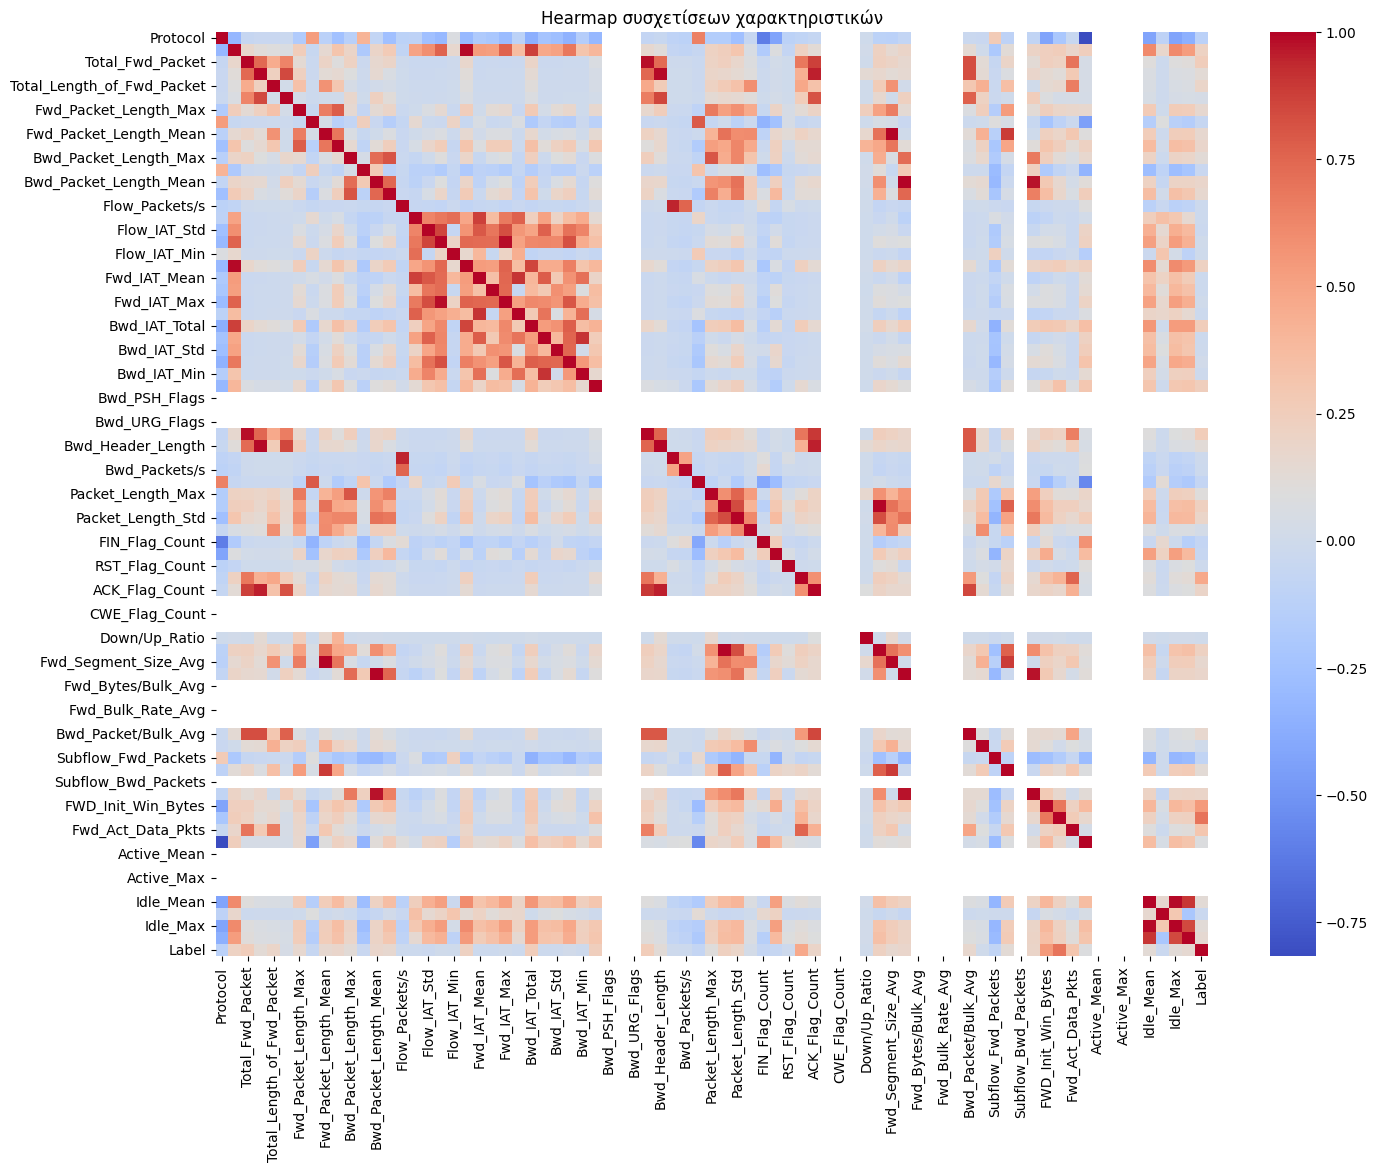

In [52]:
#EDA

#Κατανομή Tor (1) vs Non-Tor (0)
sns.countplot(data=df, x='Label')
plt.title("Κατανομή Tor (1) / Non-Tor (0)")
plt.show()

#έλεγχος για κενές τιμές
nulls = df.isnull().sum()
print("Null values:\n", nulls[nulls >0])

#μηδενικά και ακραίες τιμές
zero_vals = (df == 0).sum()
print("\n Χαρακτηριστικά με πολλά μηδενικά:\n", zero_vals[zero_vals > len(df) * 0.5])

#Heatmap με συσχετίσεις
plt.figure(figsize=(16,12))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Heatmap συσχετίσεων χαρακτηριστικών")
plt.show()

In [53]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [54]:
#εκπαίδευση αλγόριθμου
X_scaled = scaler.fit_transform(X)

In [55]:
#αντιμετώπιση Class Imbalance με SMOTE
print("Πριν SMOTE:", np.bincount(y))
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
print("Μετά SMOTE:", np.bincount(y_resampled))

Πριν SMOTE: [67139  1392]
Μετά SMOTE: [67139 67139]


In [56]:
#διαχωρισμός συνόλου δεδομένων σε σύνολο εκπαίδευσης και δοκιμών
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [63]:
#αρχικοποίηση μοντέλου
def evaluate_model(model, name):

  #τελική αξιολόγηση ανάλογα το μοντέλο
  if name in ['Random Forest', 'XGBoost', 'MLP Neural Network']:
     #εκπαίδευση αλγόριθμου
     model = model.fit(X_train, y_train)
     #πρόβλεψη συνόλου δοκιμής
     y_pred = model.predict(X_test)

     #αναλυτική αναφορά (precision, recall, f1-score)
     print(f"\n Αποτελέσματα για: {name}")
     print(classification_report(y_test, y_pred))

     #δημιουργία πίνακα σύγχυσης (confusion matrix), συγκρίνει τις πραγματικές τιμές y_test με τις προβλεπόμενες y_pred
     cm = confusion_matrix(y_test, y_pred)

     #υπολογισμός ακρίβειας (accuracy)
     acc = accuracy_score(y_test, y_pred)
     print(f"Accuracy: {acc:.2f}")

  elif name == 'Isolation Forest':
     model = model.fit(X_scaled)
     iso_preds = model.predict(X_scaled)
     #Isolation Forest επιστρέφει: 1 (inliers), -1 (outliers), υποθέτουμε ότι οι outliers είναι πιθανον οι Tor=1
     mapped_preds = [1 if p == -1 else 0 for p in iso_preds] #1 = Tor

     # αναλυτική αναφορά (precision, recall, f1-score)
     print(f"\n Αποτελέσματα για: {name}")
     print(classification_report(y, mapped_preds))

     #δημιουργία πίνακα σύγχυσης (confusion matrix), συγκρίνει τις πραγματικές τιμές y με τις προβλεπόμενες mapped_preds
     cm = confusion_matrix(y, mapped_preds)

     #υπολογισμός ακρίβειας (accuracy)
     acc = accuracy_score(y, mapped_preds)
     print(f"Accuracy: {acc:.2f}")

  #οπτικοποίηση αποτελεσμάτων
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")

  plt.title(f"{name} - Confusion Matrix")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.tight_layout()
  plt.show()


 Αποτελέσματα για: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13515
           1       1.00      1.00      1.00     13341

    accuracy                           1.00     26856
   macro avg       1.00      1.00      1.00     26856
weighted avg       1.00      1.00      1.00     26856

Accuracy: 1.00


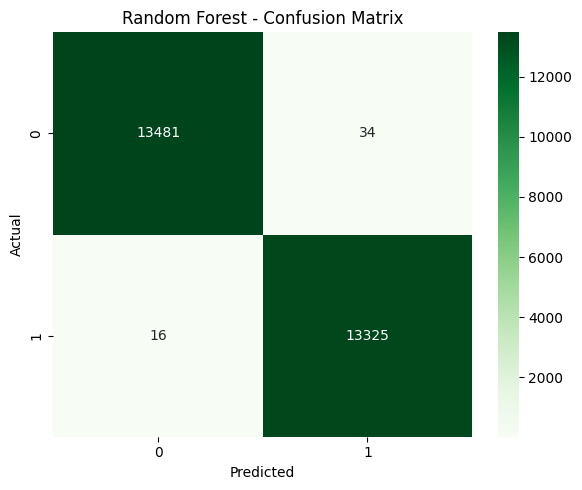

In [58]:
#δημιουργία Random Forest αλγορίθμου
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf,"Random Forest")


 Αποτελέσματα για: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13515
           1       1.00      1.00      1.00     13341

    accuracy                           1.00     26856
   macro avg       1.00      1.00      1.00     26856
weighted avg       1.00      1.00      1.00     26856

Accuracy: 1.00


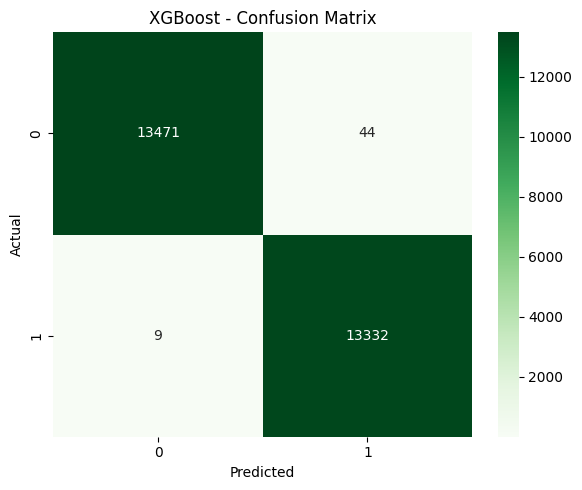

In [59]:
#δημιουργία XGBoost αλγορίθμου
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb, "XGBoost")


 Αποτελέσματα για: MLP Neural Network
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     13515
           1       0.98      0.99      0.99     13341

    accuracy                           0.99     26856
   macro avg       0.99      0.99      0.99     26856
weighted avg       0.99      0.99      0.99     26856

Accuracy: 0.99


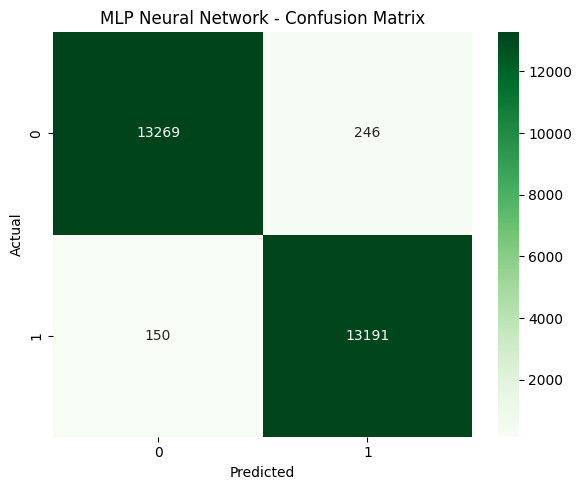

In [60]:
#δημιουργία MLP (Neural Network) αλγορίθμου
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
evaluate_model(mlp, "MLP Neural Network")


 Αποτελέσματα για: Isolation Forest
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     67139
           1       0.15      0.71      0.24      1392

    accuracy                           0.91     68531
   macro avg       0.57      0.81      0.60     68531
weighted avg       0.98      0.91      0.94     68531

Accuracy: 0.91


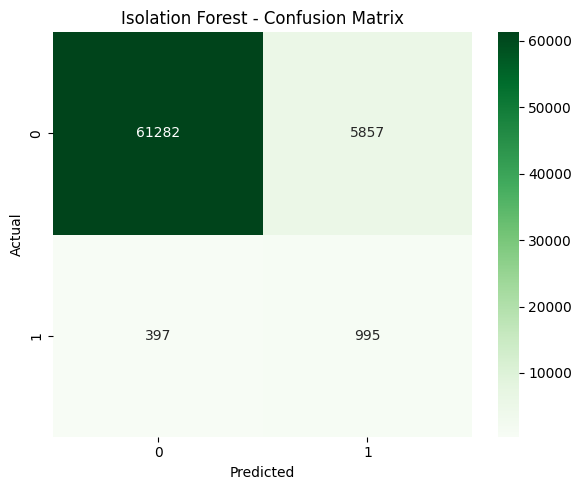

In [64]:
#δημιουργία Isolation Forest, unsupervised αλγορίθμου
iso = IsolationForest(contamination=0.1, random_state=42)
evaluate_model(iso, "Isolation Forest")